In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
file_path = "processed_event_features.h5"
with h5py.File(file_path, 'r') as f:
    event_id = f["event_id"][:]
    nhits = f["nhits"][:]
    target = f["target"][:]
    sum_energy = f["sum_energy_per_layer"][:]
    E1_E7 = f["E1_over_E7"][:]
    E7_E19 = f["E7_over_E19"][:]

num_events, num_layers = sum_energy.shape
print(num_events,num_layers)
# Build DataFrame
df = pd.DataFrame({
    "event_id": event_id,
    "nhits": nhits,
    "target": target
})

# Add per-layer features
for l in range(num_layers):
    df[f"sumE_L{l}"] = sum_energy[:, l]
    df[f"E1_E7_L{l}"] = E1_E7[:, l]
    df[f"E7_E19_L{l}"] = E7_E19[:, l]

50000 28


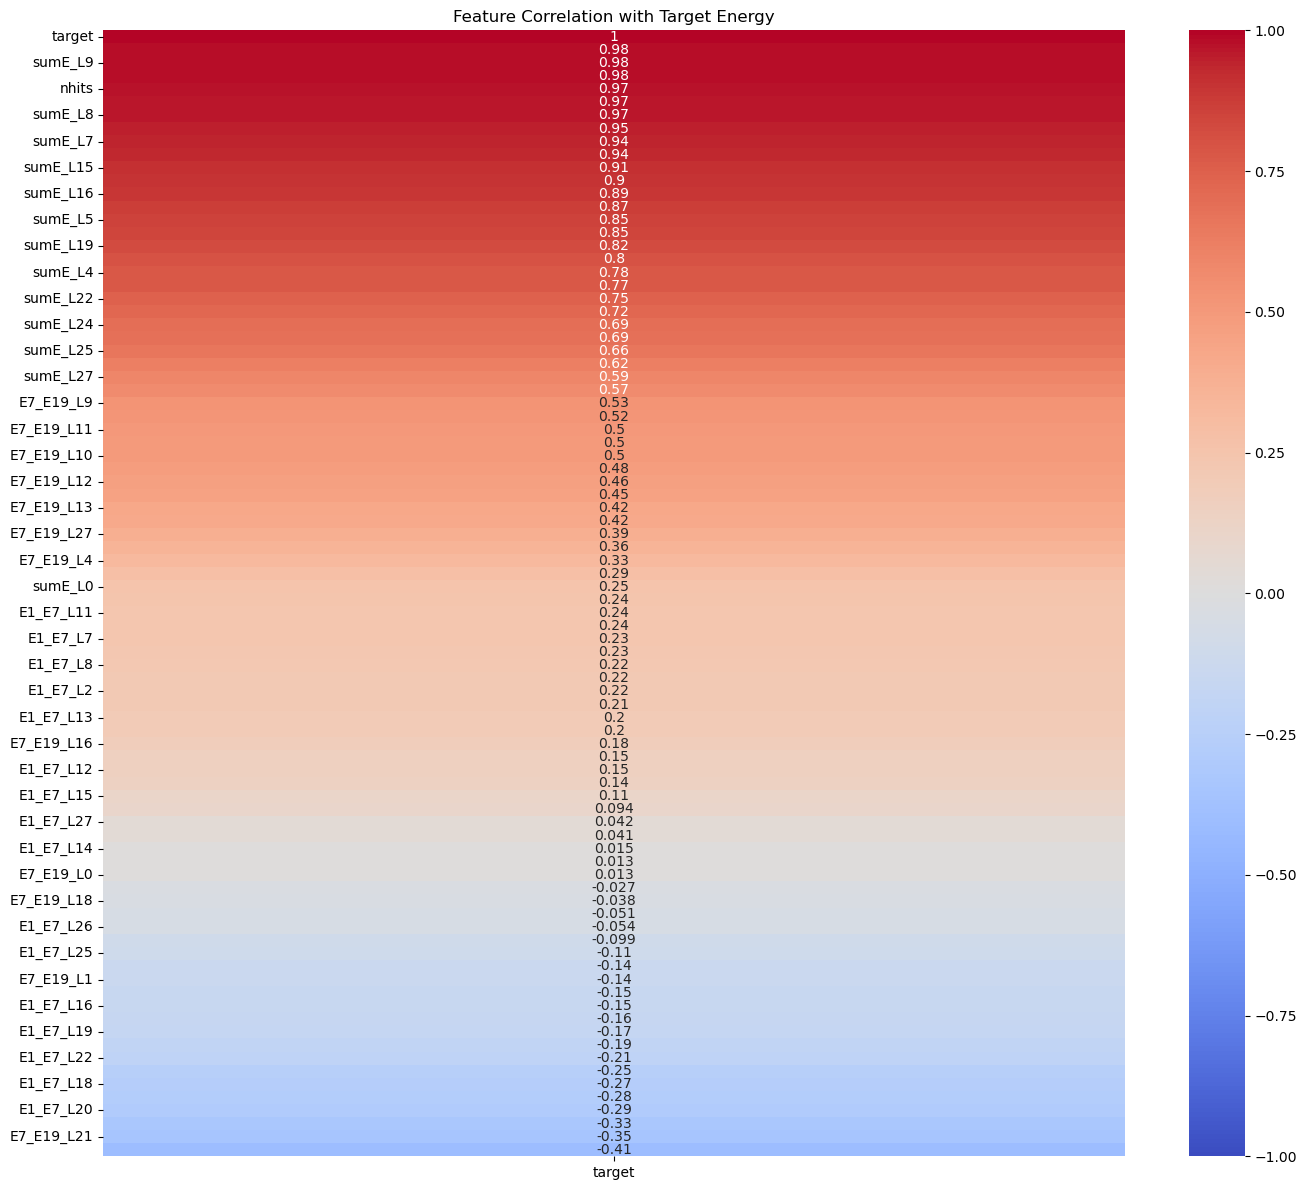

In [3]:
# Compute correlations with target
corr = df.drop(columns=['event_id']).corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr[['target']].sort_values(by='target', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation with Target Energy")
plt.tight_layout()
plt.savefig("feature_correlation_heatmap.png")
plt.show()


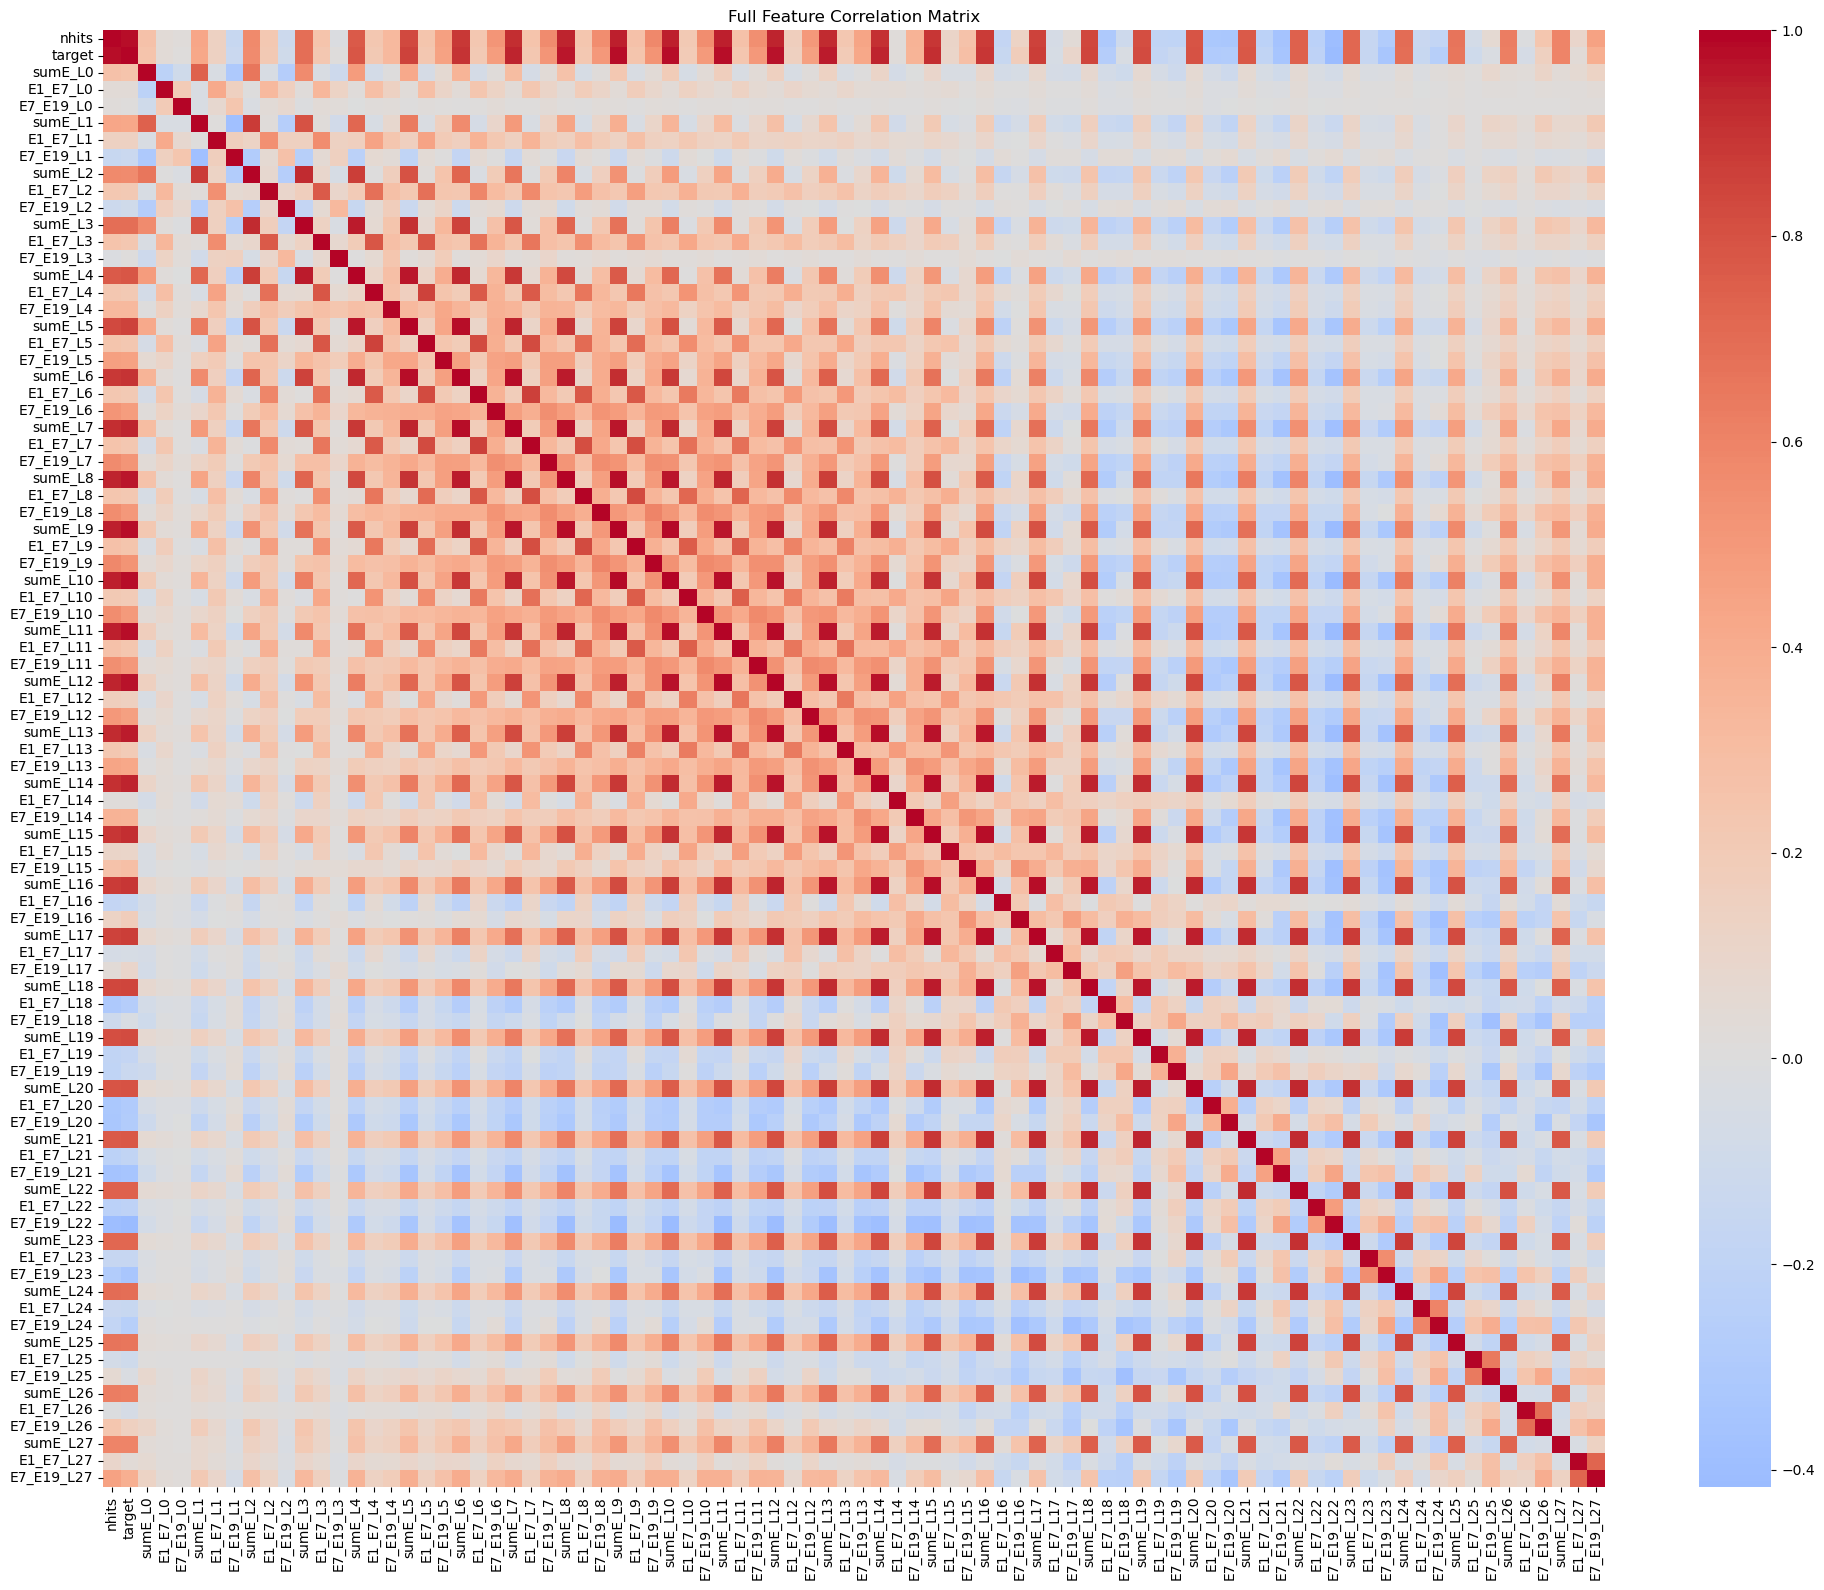

In [4]:
plt.figure(figsize=(20, 16))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Full Feature Correlation Matrix")
plt.tight_layout()
plt.savefig("full_feature_correlation_heatmap.png")
plt.show()


In [5]:
# Drop unused columns
X = df.drop(columns=['event_id', 'target','nhits'])
y = df['target']

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 40000
Test size: 10000


In [6]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("Test MSE:", mse)


The mean squared error (MSE) on test set: 18.8696
Test MSE: 18.86961232019949


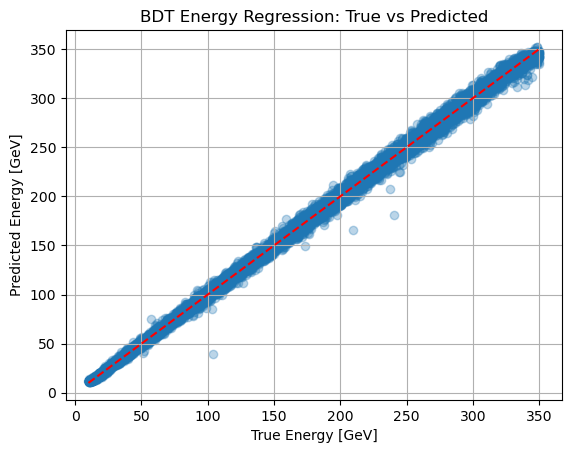

In [7]:
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("True Energy [GeV]")
plt.ylabel("Predicted Energy [GeV]")
plt.title("BDT Energy Regression: True vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.savefig("bdt_energy_regression.png")
plt.show()


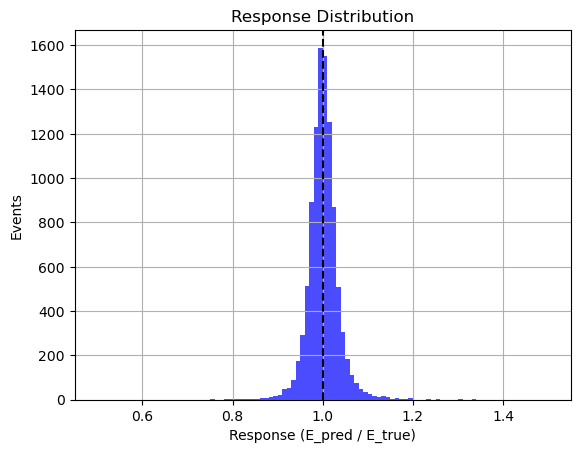

In [8]:
response = y_pred / y_test

plt.figure()
plt.hist(response, bins=100, range=(0.5, 1.5), color='blue', alpha=0.7)
plt.axvline(1.0, color='k', linestyle='--')
plt.xlabel("Response (E_pred / E_true)")
plt.ylabel("Events")
plt.title("Response Distribution")
plt.grid(True)
plt.savefig("response_distribution.png")
plt.show()


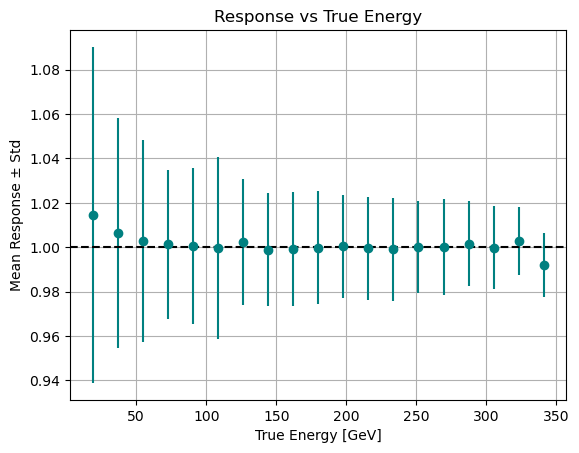

In [9]:
import numpy as np

# Bin true energy
bins = np.linspace(y_test.min(), y_test.max(), 20)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
response = y_pred / y_test

mean_response = []
std_response = []

for i in range(len(bins) - 1):
    mask = (y_test >= bins[i]) & (y_test < bins[i+1])
    resp_bin = response[mask]
    if len(resp_bin) > 0:
        mean_response.append(np.mean(resp_bin))
        std_response.append(np.std(resp_bin))
    else:
        mean_response.append(np.nan)
        std_response.append(np.nan)

# Plot
plt.errorbar(bin_centers, mean_response, yerr=std_response, fmt='o', color='teal')
plt.axhline(1.0, color='k', linestyle='--')
plt.xlabel("True Energy [GeV]")
plt.ylabel("Mean Response ± Std")
plt.title("Response vs True Energy")
plt.grid(True)
plt.savefig("response_vs_true_energy.png")
plt.show()


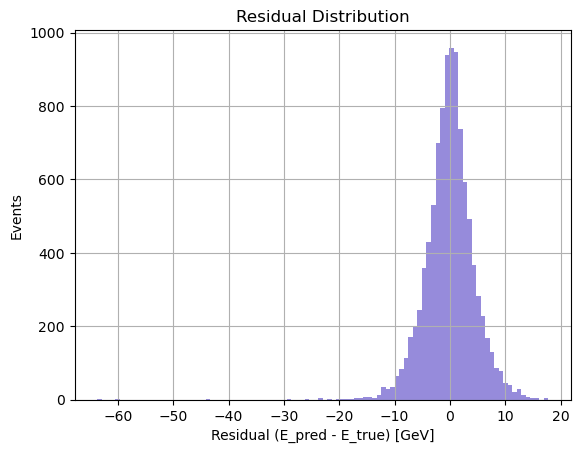

In [10]:
residual = y_pred - y_test

plt.figure()
plt.hist(residual, bins=100, color='slateblue', alpha=0.7)
plt.xlabel("Residual (E_pred - E_true) [GeV]")
plt.ylabel("Events")
plt.title("Residual Distribution")
plt.grid(True)
plt.savefig("residual_distribution.png")
plt.show()


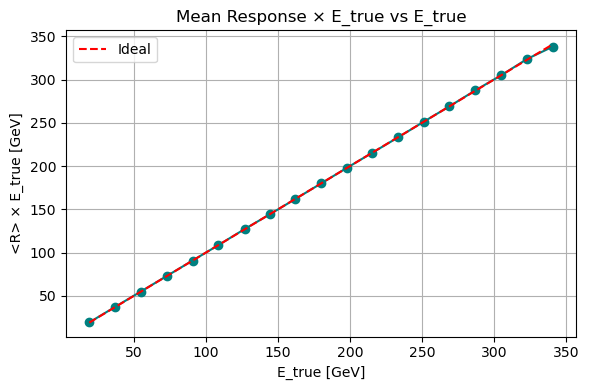

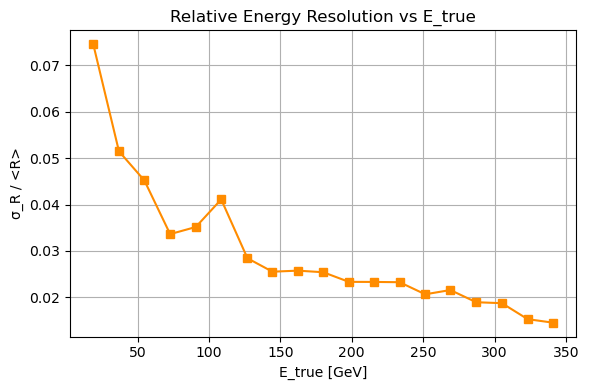

In [11]:
import numpy as np
import matplotlib.pyplot as plt

R = y_pred / y_test

# Bin true energy
bins = np.linspace(y_test.min(), y_test.max(), 20)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

mean_response = []
sigma_response = []
mean_energy = []

for i in range(len(bins) - 1):
    mask = (y_test >= bins[i]) & (y_test < bins[i+1])
    R_bin = R[mask]
    E_bin = y_test[mask]
    
    if len(R_bin) > 0:
        R_mean = np.mean(R_bin)
        sigma = np.std(R_bin)
        
        mean_response.append(R_mean)
        sigma_response.append(sigma / R_mean)  # σ_R / ⟨R⟩
        mean_energy.append(np.mean(E_bin))
    else:
        mean_response.append(np.nan)
        sigma_response.append(np.nan)
        mean_energy.append(np.nan)

# Plot 1: <R> * E_true vs E_true
plt.figure(figsize=(6, 4))
plt.plot(mean_energy, np.array(mean_response) * np.array(mean_energy), marker='o', color='teal')
plt.plot(mean_energy, mean_energy, 'r--', label="Ideal")
plt.xlabel("E_true [GeV]")
plt.ylabel("<R> × E_true [GeV]")
plt.title("Mean Response × E_true vs E_true")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("mean_response_vs_true_energy.png")
plt.show()

# Plot 2: σ_R / <R> vs E_true
plt.figure(figsize=(6, 4))
plt.plot(mean_energy, sigma_response, marker='s', color='darkorange')
plt.xlabel("E_true [GeV]")
plt.ylabel("σ_R / <R>")
plt.title("Relative Energy Resolution vs E_true")
plt.grid(True)
plt.tight_layout()
plt.savefig("relative_energy_resolution_vs_true_energy.png")
plt.show()


In [12]:
from scipy.optimize import curve_fit
# Stochastic formula
def resolution_func(E, s, c):
    return np.sqrt((s / np.sqrt(E))**2 + c**2)

# Clean the data
E_vals = np.array(mean_energy)
res_vals = np.array(sigma_response)

mask = ~np.isnan(E_vals) & ~np.isnan(res_vals)
E_fit = E_vals[mask]
res_fit = res_vals[mask]

# Fit using curve_fit
popt, pcov = curve_fit(resolution_func, E_fit, res_fit, p0=[0.2, 0.01])
s_fit, c_fit = popt
s_err, c_err = np.sqrt(np.diag(pcov))


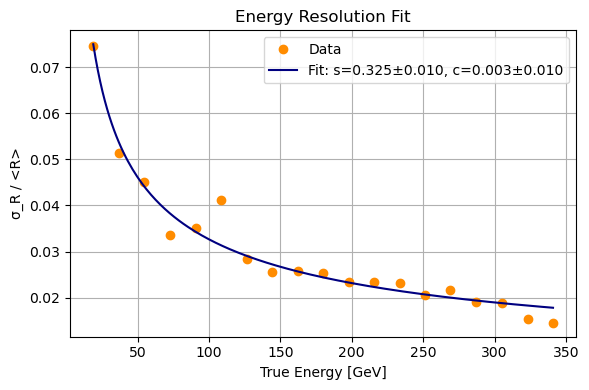

In [13]:
E_plot = np.linspace(min(E_fit), max(E_fit), 200)
fit_vals = resolution_func(E_plot, s_fit, c_fit)

plt.figure(figsize=(6, 4))
plt.plot(E_fit, res_fit, 'o', label="Data", color='darkorange')
plt.plot(E_plot, fit_vals, '-', label=f"Fit: s={s_fit:.3f}±{s_err:.3f}, c={c_fit:.3f}±{c_err:.3f}", color='navy')
plt.xlabel("True Energy [GeV]")
plt.ylabel("σ_R / <R>")
plt.title("Energy Resolution Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("energy_resolution_fit.png")
plt.show()


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE and MSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# MRE (mean relative error)
mre = np.mean(np.abs((y_pred - y_test) / y_test))

# Print results
print(f"MAE: {mae:.4f} GeV")
print(f"MSE: {mse:.4f} GeV²")
print(f"MRE: {mre:.4f}")


MAE: 3.1811 GeV
MSE: 18.8696 GeV²
MRE: 0.0236


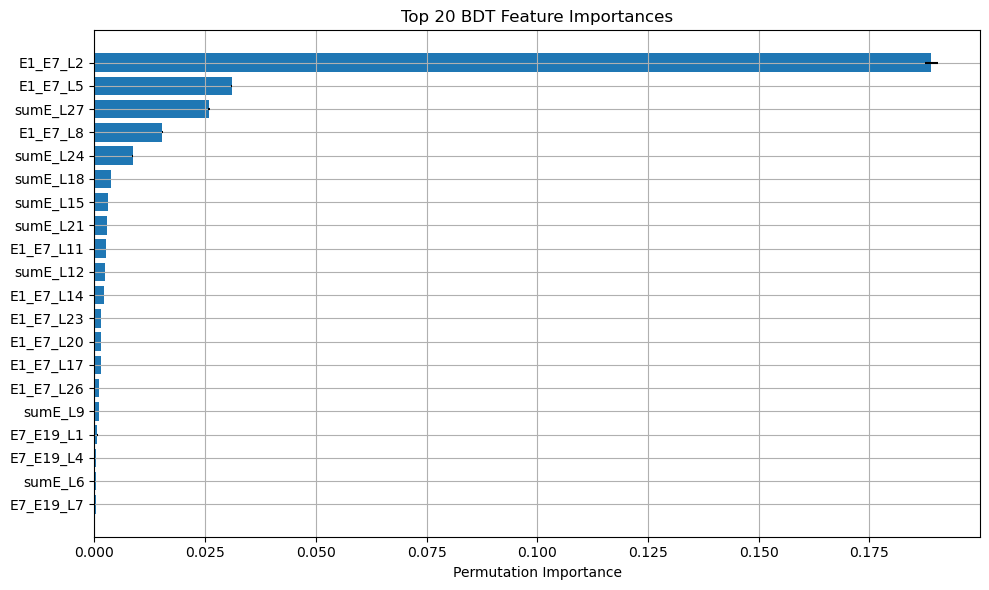

In [ ]:
from sklearn.inspection import permutation_importance

layer_ids = range(num_layers) 
feature_names = [f"sumE_L{l}" for l in layer_ids] + \
                [f"E1_E7_L{l}" for l in layer_ids] + \
                [f"E7_E19_L{l}" for l in layer_ids]

# Sort by importance
# model must support predict()
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

importances = result.importances_mean
stds = result.importances_std

# Plot
sorted_idx = np.argsort(importances)[::-1]
sorted_names = np.array(feature_names)[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_names[:20][::-1], importances[sorted_idx][:20][::-1], xerr=stds[sorted_idx][:20][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 20 BDT Feature Importances")
plt.grid(True)
plt.tight_layout()
plt.savefig('feature_importance_bdt.png')
plt.show()